# Reading data
---

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import pandas as pd


df_bitcoin = pd.read_csv("/content/drive/MyDrive/Pós-Graduação/Mineração de Dados/coin_Bitcoin.csv")

In [7]:
df_bitcoin.head()

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
0,1,Bitcoin,BTC,2013-04-29 23:59:59,147.488007,134.000000,134.444000,144.539993,0.0,1.603769e+09
1,2,Bitcoin,BTC,2013-04-30 23:59:59,146.929993,134.050003,144.000000,139.000000,0.0,1.542813e+09
2,3,Bitcoin,BTC,2013-05-01 23:59:59,139.889999,107.720001,139.000000,116.989998,0.0,1.298955e+09
3,4,Bitcoin,BTC,2013-05-02 23:59:59,125.599998,92.281898,116.379997,105.209999,0.0,1.168517e+09
4,5,Bitcoin,BTC,2013-05-03 23:59:59,108.127998,79.099998,106.250000,97.750000,0.0,1.085995e+09


In [8]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=df_bitcoin.Date,
        y=df_bitcoin.Close
    )
)

fig.show()

# Feature engineering
---

In [9]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=df_bitcoin.Date,
        y=df_bitcoin.Close.diff()
    )
)

fig.show()

In [10]:
# Creating label
df_bitcoin["Close_Diff"] = df_bitcoin.Close.diff()

In [11]:
100 * df_bitcoin["Close_Diff"] / df_bitcoin.Close

0             NaN
1       -3.985607
2      -18.813576
3      -11.196653
4       -7.631713
          ...    
2857   -11.024998
2858     1.772257
2859    -5.545268
2860    -1.627313
2861    -0.327590
Length: 2862, dtype: float64

In [12]:
df_bitcoin["label"] = df_bitcoin["Close_Diff"] > 0

df_bitcoin["label"].sum() / df_bitcoin.shape[0]

0.5419287211740041

In [14]:
df_bitcoin.head()

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap,Close_Diff,label
0,1,Bitcoin,BTC,2013-04-29 23:59:59,147.488007,134.000000,134.444000,144.539993,0.0,1.603769e+09,NaN,False
1,2,Bitcoin,BTC,2013-04-30 23:59:59,146.929993,134.050003,144.000000,139.000000,0.0,1.542813e+09,-5.539993,False
2,3,Bitcoin,BTC,2013-05-01 23:59:59,139.889999,107.720001,139.000000,116.989998,0.0,1.298955e+09,-22.010002,False
3,4,Bitcoin,BTC,2013-05-02 23:59:59,125.599998,92.281898,116.379997,105.209999,0.0,1.168517e+09,-11.779999,False
4,5,Bitcoin,BTC,2013-05-03 23:59:59,108.127998,79.099998,106.250000,97.750000,0.0,1.085995e+09,-7.459999,False


In [15]:
import numpy as np

def build_feature(df, 
                  feature_columns=["High", "Low", "Open", "Close", "Marketcap"],
                  degree=4):
    """Criação de features baseadas no histórico das séries temporais."""
    
    features = []
    for k in range(degree):
        nx = k + 1
        feat_cols = [f"{c}_{nx}" for c in feature_columns]
        features += feat_cols
        
        # Defining feature data
        df_feat = pd.DataFrame(df[feature_columns])
        df_feat.columns = feat_cols
        
        # Creating NaN values 
        NaN_list = len(feature_columns) * [np.nan]
        NaN_data = nx * [NaN_list]
        df_NaN = pd.DataFrame(NaN_data, columns=feat_cols)
        
        df_feat = df_feat.iloc[:-nx]
        
        df_feat = pd.concat([df_NaN, df_feat], axis=0, ignore_index=True)
        
        df = pd.concat([df, df_feat], axis=1)
        
    return df, features

In [16]:
df, feature_cols = build_feature(df_bitcoin.copy())

In [17]:
df[[f for f in feature_cols if "High" in f]].head()

,High_1,High_2,High_3,High_4
0,NaN,NaN,NaN,NaN
1,147.488007,NaN,NaN,NaN
2,146.929993,147.488007,NaN,NaN
3,139.889999,146.929993,147.488007,NaN
4,125.599998,139.889999,146.929993,147.488007


In [18]:
df, feature_cols = build_feature(
    df_bitcoin.copy(),
    feature_columns=["High", "Low", "Open", "Close", "Marketcap"],
    degree=150)

In [19]:
from datetime import datetime

def processing_date(df, date_col=["Date"]):
    """
    """
    
    for d in date_col:
        df[d] = df[d].apply(lambda v: datetime.strptime(v, "%Y-%m-%d %H:%M:%S"))
        df[f"{d}_day"] = df[d].apply(lambda v: v.day)
        df[f"{d}_month"] = df[d].apply(lambda v: v.month)
    return df

In [20]:
df = processing_date(df, date_col=["Date"])

In [21]:
df

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap,Close_Diff,label,High_1,Low_1,Open_1,Close_1,Marketcap_1,High_2,Low_2,Open_2,Close_2,Marketcap_2,High_3,Low_3,Open_3,Close_3,Marketcap_3,High_4,Low_4,Open_4,Close_4,Marketcap_4,High_5,Low_5,Open_5,Close_5,Marketcap_5,High_6,Low_6,Open_6,...,Open_143,Close_143,Marketcap_143,High_144,Low_144,Open_144,Close_144,Marketcap_144,High_145,Low_145,Open_145,Close_145,Marketcap_145,High_146,Low_146,Open_146,Close_146,Marketcap_146,High_147,Low_147,Open_147,Close_147,Marketcap_147,High_148,Low_148,Open_148,Close_148,Marketcap_148,High_149,Low_149,Open_149,Close_149,Marketcap_149,High_150,Low_150,Open_150,Close_150,Marketcap_150,Date_day,Date_month
0,1,Bitcoin,BTC,2013-04-29 23:59:59,147.488007,134.000000,134.444000,144.539993,0.000000e+00,1.603769e+09,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29,4
1,2,Bitcoin,BTC,2013-04-30 23:59:59,146.929993,134.050003,144.000000,139.000000,0.000000e+00,1.542813e+09,-5.539993,False,147.488007,134.000000,134.444000,144.539993,1.603769e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30,4
2,3,Bitcoin,BTC,2013-05-01 23:59:59,139.889999,107.720001,139.000000,116.989998,0.000000e+00,1.298955e+09,-22.010002,False,146.929993,134.050003,144.000000,139.000000,1.542813e+09,147.488007,134.000000,134.444000,144.539993,1.603769e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,5
3,4,Bitcoin,BTC,2013-05-02 23:59:59,125.599998,92.281898,116.379997,105.209999,0.000000e+00,1.168517e+09,-11.779999,False,139.889999,107.720001,139.000000,116.989998,1.298955e+09,146.929993,134.050003,144.000000,139.000000,1.542813e+09,147.488007,134.000000,134.444000,144.539993,1.603769e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,5
4,5,Bitcoin,BTC,2013-05-03 23:59:59,108.127998,79.099998,106.250000,97.750000,0.000000e+00,1.085995e+09,-7.459999,False,125.599998,92.281898,116.379997,105.209999,1.168517e+09,139.889999,107.720001,139.000000,116.989998,1.298955e+09,146.929993,134.050003,144.000000,139.000000,1.542813e+09,147.488007,134.000000,134.444000,144.539993,1.603769e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2857,2858,Bitcoin,BTC,2021-02-23 23:59:59,54204.929756,45290.590268,54204.929756,48824.426869,1.061025e+11,9.099259e+11,-5382.892196,False,57533.389325,48967.565188,57532.738864,54207.319065,1.010205e+12,58330.572142,55672.609513,56068.568246,57539.943668,1.072263e+12,57505.228187,54626.559776,55887.335714,56099.520513,1.045371e+12,56113.650547,50937.275722,51675.981285,55888.133682,1.041381e+12,52474.107249,51015.764554,52140.972717,51679.796694,9.629151e+11,52533.914312,49072.377140,49207.276432,...,10575.100636,10549.328900,1.952332e+11,10657.837986,10416.689205,10619.821216,10575.975042,1.957161e+11,10933.624309,10472.35651

# Data preprocessing
---

In [ ]:
df.dropna(inplace=True)

In [ ]:
df.shape

(2712, 764)

In [ ]:
X = df[feature_cols + ["Date_day", "Date_month"]]
y = df["label"]

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [ ]:
!pip install sktime

     |████████████████████████████████| 5.7 MB 3.4 MB/s eta 0:00:01
     |████████████████████████████████| 3.4 MB 65.2 MB/s eta 0:00:01
     |████████████████████████████████| 9.5 MB 20.7 MB/s eta 0:00:01
     |████████████████████████████████| 25.3 MB 24.6 MB/s eta 0:00:01
     |████████████████████████████████| 231 kB 72.6 MB/s eta 0:00:01


In [ ]:
from sktime.forecasting.model_selection import temporal_train_test_split

X_train, X_test, y_train, y_test = temporal_train_test_split(X, y, test_size=0.3)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

mms = MinMaxScaler()
mms.fit(X_train, y_train)

MinMaxScaler()

# Training model
---

In [ ]:
import xgboost as xgb

X_ = mms.transform(X_train)

clf = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=15,
    use_label_encoder=False
)

clf.fit(X_, y_train)

[21:26:58] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=300, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

# Validating Model
---

In [ ]:
X_test

,High_1,Low_1,Open_1,Close_1,Marketcap_1,High_2,Low_2,Open_2,Close_2,Marketcap_2,...,Open_149,Close_149,Marketcap_149,High_150,Low_150,Open_150,Close_150,Marketcap_150,Date_day,Date_month
2048,3874.966031,3521.101724,3754.074467,3521.101724,6.130397e+10,3969.535852,3753.994827,3958.894725,3753.994827,6.535250e+10,...,6330.770020,6394.709961,1.096319e+11,6767.740234,6320.720215,6739.209961,6329.950195,1.085110e+11,7,12
2049,3512.590409,3280.228752,3512.590409,3419.937200,5.954765e+10,3874.966031,3521.101724,3754.074467,3521.101724,6.130397e+10,...,6396.779785,6228.810059,1.067989e+11,6444.959961,6330.470215,6330.770020,6394.709961,1.096319e+11,8,12
2050,3506.043392,3350.650703,3421.910403,3476.114715,6.053128e+10,3512.590409,3280.228752,3512.590409,3419.937200,5.954765e+10,...,6235.029785,6238.049805,1.069684e+11,6397.100098,6136.419922,6396.779785,6228.810059,1.067989e+11,9,12
2051,3685.305600,3469.094358,3473.227620,3614.234273,6.294216e+10,3506.043392,3350.650703,3421.910403,3476.114715,6.053128e+10,...,6247.500000,6276.120117,1.076315e+11,6310.549805,6192.240234,6235.029785,6238.049805,1.069684e+11,10,12
2052,3647.332582,3470.144420,3612.046395,3502.655996,6.100445e+10,3685.305600,3469.094358,3473.227620,3614.234273,6.294216e+10,...,6272.700195,6359.640137,1.090746e+11,6298.189941,6212.220215,6247.500000,6276.120117,1.076315e+11,11,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2857,57533.389325,48967.565188,57532.738864,54207.319065,1.010205e+12,58330.572142,55672.609513,56068.568246,57539.943668,1.072263e+12,...,10746.892758,10775.269376,1.993580e+11,10772.998660,10667.280934,10695.575082,10750.723579,1.988930e+11,23,2
2858,54204.929756,45290.590268,54204.929756,48824.426869,9.099259e+11,57533.389325,48967.565188,57532.738864,54207.319065,1.010205e+12,...,10776.613639,10709.652182,1.981541e+11,10803.976080,10622.921758,10746.892758,10775.269376,1.993580e+11,24,2
2859,51290.136695,47213.498162,48835.087661,49705.333316,9.263931e+11,54204.929756,45290.590268,54204.929756,48824.426869,9.099259e+11,...,10709.650022,10844.640981,2.006601e+11,10945.347907,10703.893251,10776.613639,10709.652182,1.981541e+11,25,2
2860,51948.966982,47093.853019,49709.082425,47093.853019,8.777661e+11,51290.136695,47213.498162,48835.087661,49705.333316,9.263931e+11,...,10843.870751,10784.491578,1.995570e+11,10860.000698,10649.495439,10709.650022,10844.640981,2.006601e+11,26,2


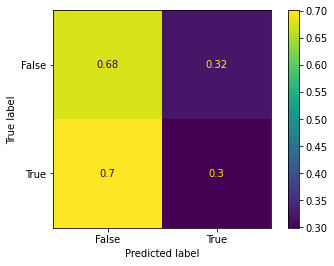

In [ ]:
from sklearn.metrics import plot_confusion_matrix

X_test_proc = mms.transform(X_test)

plot_confusion_matrix(clf, X_test_proc, y_test, normalize="true")

The model is good to predict results FF (68%) but is not good to predict results TT (30%). 